# Show Monte Carlo results for KF estimators

In [1]:
import numpy as np
from simulation.generate_path import generate_path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from estimation.distance_sensor import distance_sensors
from estimation.iterative_estimator import iterative_estimator
from estimation.kalman_filter_from_points_with_acc import kalman_filter_from_points_acc
from estimation.improved_kalman_filter_from_points_with_acc import improved_kalman_filter_from_points_acc
from estimation.KF_with_mahalanobis_threshold import kalman_filter_with_mahalanobis

# For making the plots interactive, uncomment next line:
# %matplotlib widget


/home/user/miniconda3/envs/cuda_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create the path

target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3 #24 for sharp turn
time_res = 0.1
sensor_sigma = 15

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

In [3]:
MC_iterations = 100
outlier_percentage = 1
outlier_sigma=500
sigma_a = 1
sigma_v = 100
sensor_location = [[-5000,0,0],[ 400, -7400, 0],[800, 800, 0]]

total_err_it_est = np.zeros(path1.path.shape[0])
total_err_kf_acc = np.zeros(path1.path.shape[0])
total_err_NN_kf_acc = np.zeros(path1.path.shape[0])
total_err_kf_mahal = np.zeros(path1.path.shape[0])
sensors = distance_sensors(sensor_location, sensor_sigma, outlier_percentage=outlier_percentage, outlier_sigma=outlier_sigma)
skipped_runs = 0

total_true_positive_rate = 0
total_false_positive_rate = 0
total_false_negative_rate = 0

total_vel_err_NN_xy = 0
total_vel_err_mahal_xy = 0
total_vel_err_NN_z = 0
total_vel_err_mahal_z = 0

for i in range(MC_iterations):
    try:
        # Randomize noise
        sensors.calculate_measurements(path1.path)
        # sensors_noisy.calculate_measurements(path1.path)
        # estimate the path with each estimator
        it_est = iterative_estimator(sensors, path1.path[0,:])
        it_estimated_path = it_est.estimate_path(precision_limit=1)
        cov_mat_it = it_est.get_cov_err_with_sigma(it_estimated_path, sigma=15)

                
        improved_KF = improved_kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
        kf_acc = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
        kf_mahal = kalman_filter_with_mahalanobis(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, mahalanobis_threshold=3, initial_P_multiplier=1000000)
                
        kf_path_acc = kf_acc.filter_path(it_estimated_path)
        kf_path_NN, kf_NN_vel = improved_KF.filter_path(it_estimated_path, cov=cov_mat_it, should_return_velocity=True)
        kf_path_mahal, mahal_skipped_samples, mahalanobis_dists, kf_mahal_vel = kf_mahal.filter_path(it_estimated_path, cov=cov_mat_it, outlier_max=None, should_return_velocity=True)

        # calculate current error
        estimation_error_iter = np.sqrt(np.sum(np.square(it_estimated_path-path1.path), 1))
        estimation_error_kf_acc = np.sqrt(np.sum(np.square(kf_path_acc-path1.path), 1))
        estimation_error_NN_kf_acc = np.sqrt(np.sum(np.square(kf_path_NN-path1.path), 1))
        estimation_error_kf_mahal = np.sqrt(np.sum(np.square(kf_path_mahal-path1.path), 1))

        # ignore runs with crazy errors
        if max(np.max(estimation_error_kf_mahal), np.max(estimation_error_NN_kf_acc), np.max(estimation_error_kf_acc)) > 1000:
            skipped_runs += 1
            continue

        # update average error
        total_err_it_est += estimation_error_iter
        total_err_kf_acc += estimation_error_kf_acc
        total_err_NN_kf_acc += estimation_error_NN_kf_acc
        total_err_kf_mahal += estimation_error_kf_mahal

        
        total_vel_err_NN_xy += np.abs(np.sqrt(np.square(kf_NN_vel[0,:]) + np.square(kf_NN_vel[1,:])) - 50)
        total_vel_err_NN_z += np.abs(kf_NN_vel[2,:] - 10)
        total_vel_err_mahal_xy += np.abs(np.sqrt(np.square(kf_mahal_vel[0,:]) + np.square(kf_mahal_vel[1,:])) - 50)
        total_vel_err_mahal_z += np.abs(kf_mahal_vel[2,:] - 10)

        # update true and false positive and negative rates
        # true_positive = np.count_nonzero(np.logical_and(mahal_skipped_samples, sensors.outlier_distances))
        # false_positive = np.count_nonzero(mahal_skipped_samples) - true_positive
        # true_negative = np.count_nonzero(np.logical_not(np.logical_or(mahal_skipped_samples, sensors.outlier_distances)))
        # false_negative = np.count_nonzero(np.logical_not(mahal_skipped_samples)) - true_negative

        # true_positive_rate = true_positive / (true_positive + false_positive)
        # false_positive_rate = false_positive / (true_positive + false_positive)
        # false_negative_rate = false_negative / (true_negative + false_negative)

        # total_true_positive_rate += true_positive_rate
        # total_false_positive_rate += false_positive_rate
        # total_false_negative_rate += false_negative_rate

    except KeyboardInterrupt:
        print(f"stopped after {i} iterations")
        i = i-1
        break

i -= skipped_runs

mean_err_it_est = total_err_it_est / (i+1)
mean_err_kf_acc = total_err_kf_acc / (i+1)
mean_err_NN_kf_acc = total_err_NN_kf_acc / (i+1)
mean_err_kf_mahal = total_err_kf_mahal / (i+1)

mean_vel_err_NN_xy = total_vel_err_NN_xy / (i+1)
mean_vel_err_NN_z = total_vel_err_NN_z / (i+1)
mean_vel_err_mahal_xy = total_vel_err_mahal_xy / (i+1)
mean_vel_err_mahal_z = total_vel_err_mahal_z / (i+1)

# mean_true_positive_rate = total_true_positive_rate / (i+1)
# mean_false_positive_rate = total_false_positive_rate / (i+1)
# mean_false_negative_rate = total_false_negative_rate / (i+1)

print(f"skipped {skipped_runs} runs")

# print(f"{mean_true_positive_rate=} {mean_false_positive_rate=} {mean_false_negative_rate=}")



skipped 0 runs


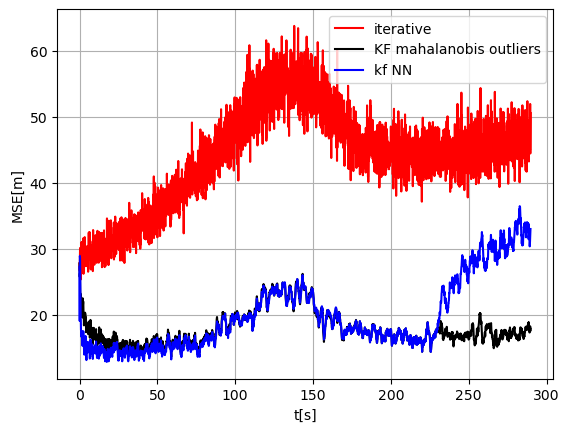

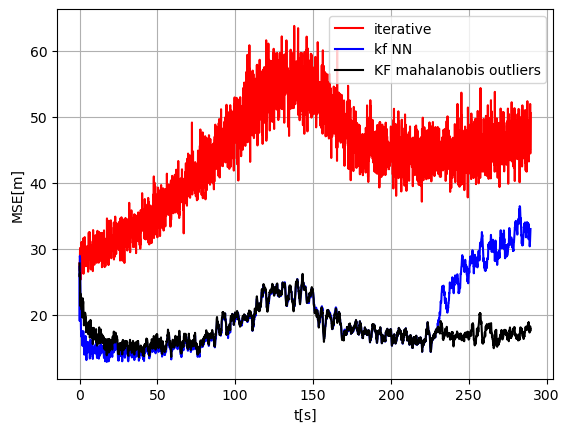

In [4]:
t = path1.time

plt.figure()
plt.plot(t, mean_err_it_est, label=f'iterative', color='r')
# plt.plot(t, mean_err_kf_acc, label=f'original KF', color='g')
plt.plot(t, mean_err_kf_mahal, label=f'KF mahalanobis outliers', color='k')
plt.plot(t, mean_err_NN_kf_acc, label=f'kf NN', color='b')
plt.xlabel('t[s]')
plt.ylabel('MSE[m]')
plt.grid()
plt.legend()
# plt.xlim([0,10])
# plt.ylim([0,2000])
plt.show()

plt.figure()
plt.plot(t, mean_err_it_est, label=f'iterative', color='r')
# plt.plot(t, mean_err_kf_acc, label=f'original KF', color='g')
plt.plot(t, mean_err_NN_kf_acc, label=f'kf NN', color='b')
plt.plot(t, mean_err_kf_mahal, label=f'KF mahalanobis outliers', color='k')
plt.xlabel('t[s]')
plt.ylabel('MSE[m]')
plt.grid()
plt.legend()
# plt.xlim([0,10])
# plt.ylim([0,2000])
plt.show()



In [5]:
if MC_iterations == 1:
    plt.figure()
    plt.plot(t, sensors.outlier_distances, linestyle='None', label=f'actual outlier', marker='^', color='r')
    plt.plot(t, mahal_skipped_samples, linestyle='None', label=f'outlier detected', marker='.', color='b')
    plt.xlabel('t[s]')
    plt.ylabel('outliers')
    plt.grid()
    plt.legend()
    plt.xlim([0,10])
    plt.show()

    plt.figure()
    # plt.plot(t, sensors.outlier_distances*10000000, color='y')
    # plt.plot(t, mahal_skipped_samples*10000000, color='y')
    plt.plot(t, mahalanobis_dists, linestyle='None', marker='.', color='r')
    plt.xlabel('t[s]')
    linestyle='None'
    plt.ylabel('mahalanobis dist')
    plt.grid()
    plt.xlim([0,10])
    plt.show()

avg_xy_vel=51.36672661519948, mean_xy_vel=51.36672661519948
avg_z_vel=9.875677258229777, mean_z_vel=9.875677258229777


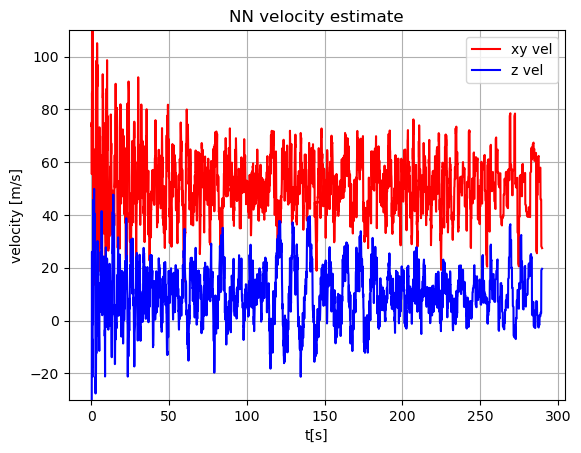

avg_xy_vel=52.4466747149835, mean_xy_vel=52.4466747149835
avg_z_vel=9.900223370503086, mean_z_vel=9.900223370503086


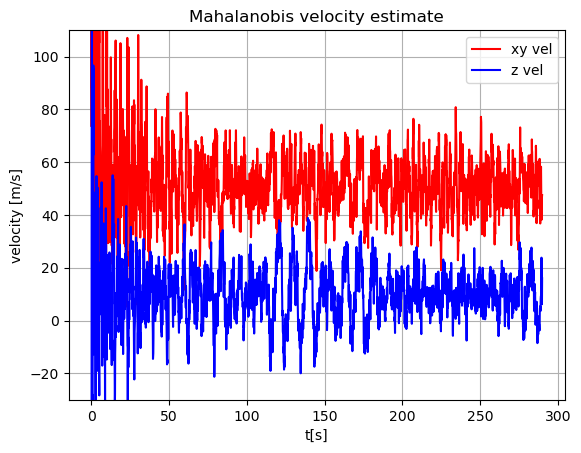

In [14]:

xy_vel = np.sqrt(np.square(kf_NN_vel[0,:]) + np.square(kf_NN_vel[1,:]))
z_vel = kf_NN_vel[2,:]

avg_xy_vel = np.average(xy_vel)
mean_xy_vel = np.mean(xy_vel)

avg_z_vel = np.average(z_vel)
mean_z_vel = np.mean(z_vel)

print(f"{avg_xy_vel=}, {mean_xy_vel=}")
print(f"{avg_z_vel=}, {mean_z_vel=}")


plt.figure()
plt.plot(t, xy_vel, color='r', label='xy vel')
plt.plot(t, z_vel, color='b', label='z vel')
plt.xlabel('t[s]')
plt.ylabel('velocity [m/s]')
plt.grid()
plt.title('NN velocity estimate')
plt.legend()
plt.ylim([-30,110])
plt.show()


xy_vel = np.sqrt(np.square(kf_mahal_vel[0,:]) + np.square(kf_mahal_vel[1,:]))
z_vel = kf_mahal_vel[2,:]

avg_xy_vel = np.average(xy_vel)
mean_xy_vel = np.mean(xy_vel)

avg_z_vel = np.average(z_vel)
mean_z_vel = np.mean(z_vel)

print(f"{avg_xy_vel=}, {mean_xy_vel=}")
print(f"{avg_z_vel=}, {mean_z_vel=}")


plt.figure()
plt.plot(t, xy_vel, color='r', label='xy vel')
plt.plot(t, z_vel, color='b', label='z vel')
plt.xlabel('t[s]')
plt.ylabel('velocity [m/s]')
plt.grid()
plt.title('Mahalanobis velocity estimate')
plt.legend()
plt.ylim([-30,110])
plt.show()


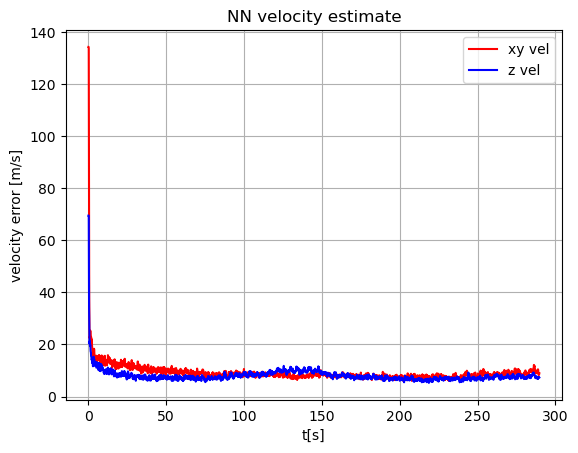

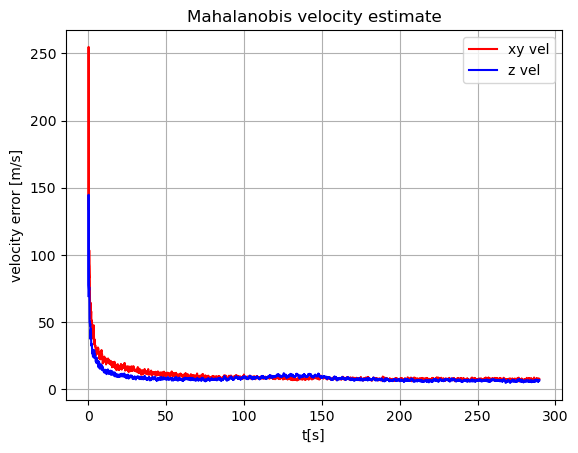

In [7]:

plt.figure()
plt.plot(t, mean_vel_err_NN_xy, color='r', label='xy vel')
plt.plot(t, mean_vel_err_NN_z, color='b', label='z vel')
plt.xlabel('t[s]')
plt.ylabel('velocity error [m/s]')
plt.grid()
plt.title('NN velocity estimate')
plt.legend()
plt.show()


plt.figure()
plt.plot(t, mean_vel_err_mahal_xy, color='r', label='xy vel')
plt.plot(t, mean_vel_err_mahal_z, color='b', label='z vel')
plt.xlabel('t[s]')
plt.ylabel('velocity error [m/s]')
plt.grid()
plt.title('Mahalanobis velocity estimate')
plt.legend()
plt.show()


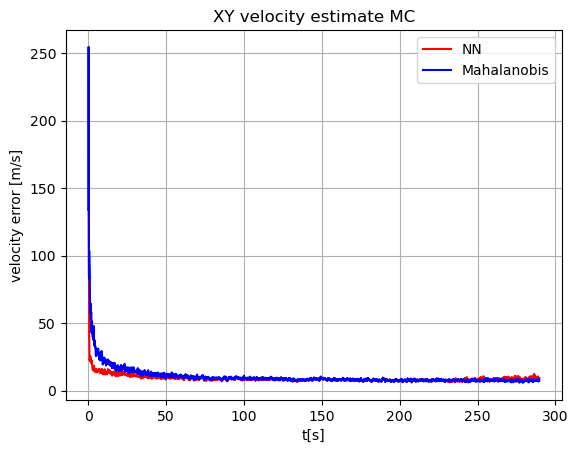

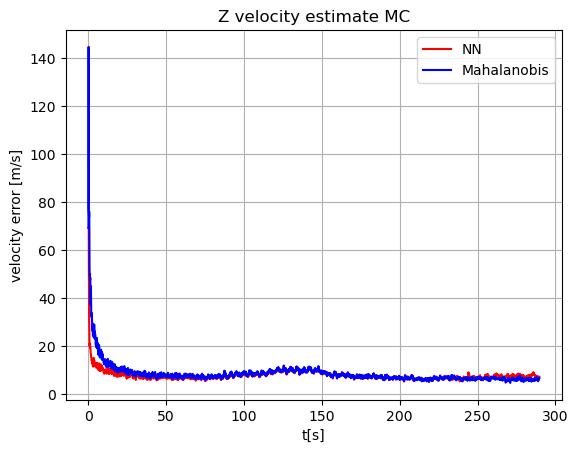

In [11]:
plt.figure()
plt.plot(t, mean_vel_err_NN_xy, color='r', label='NN')
plt.plot(t, mean_vel_err_mahal_xy, color='b', label='Mahalanobis')
plt.xlabel('t[s]')
plt.ylabel('velocity error [m/s]')
plt.grid()
plt.title('XY velocity estimate MC')
plt.legend()
plt.show()


plt.figure()
plt.plot(t, mean_vel_err_NN_z, color='r', label='NN')
plt.plot(t, mean_vel_err_mahal_z, color='b', label='Mahalanobis')
plt.xlabel('t[s]')
plt.ylabel('velocity error [m/s]')
plt.grid()
plt.title('Z velocity estimate MC')
plt.legend()
plt.show()